In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
import scipy.optimize

In [2]:
ke2 = 197 / 137 # eV-nm   Coulomb force charge
alpha = 1.09e3  # eV      parameter of model
rho = 0.0321    # nm      parameter of model
b = 1.0         # eV      regular
c = 0.01        # nm

In [3]:

#Helpful solution to convert itertools combinations to numpy arrays here:
## https://stackoverflow.com/questions/33282369/convert-itertools-array-into-numpy-array
def cp(l):
    return np.fromiter(itertools.chain(*itertools.combinations(l,2)),dtype=int).reshape(-1,2)

class Cluster:
    def __init__(self, r_na, r_cl):
        '''
        Inputs the list of Na and Cl positions. Na has charge +1, Cl has -1.
        The array of ions itself does not change throughout the calculation, and
        neither do the charges. As such, we can just compute the combinations one time
        and refer to it throughout the calculation. 
        '''
        self.positions = np.concatenate( (r_na,r_cl))
        self.charges = np.concatenate( [np.ones(r_na.shape[0]), np.full(r_cl.shape[0], -1)] )
        self.combs = cp(np.arange(self.charges.size))
        self.chargeprods = self.charges[self.combs][:,0] * self.charges[self.combs][:,1]
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)

    def Uij(self):
        '''Calculate a numpy vector of all of the potentials of the combinations'''
        self.Uij_ = np.zeros_like(self.rij)
        pos = self.chargeprods>0
        neg = ~pos
        self.Uij_[pos] = ke2 / self.rij[pos] + b*(c/self.rij[pos])**12
        self.Uij_[neg] =-ke2 / self.rij[neg] + alpha*np.exp(-self.rij[neg]/rho) + b*(c/self.rij[neg])**12
        return self.Uij_
    
    def U(self):
        '''Total potential, which is a sum of the Vij vector'''
        return np.sum(self.Uij())
    
    def binding_energy(self):
        '''
        Calculate the binding energy using the formula:
        E_B = 1/2 * sum_{i != j} U_ij
        '''
        binding_energy = 0.5 * np.sum(self.Uij())
        return binding_energy
    
    def get_vals(self):
        '''Positions interpreted as a flat shape'''
        return np.reshape(self.positions, -1)
        
    def set_vals(self, vals ):        
        '''Inputs flat shape of positions, used by __call__'''
        self.positions = vals.reshape(self.positions.shape)
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)

    
    def __call__(self, vals):
        '''Function that  scipy.optimize.minimize will call'''
        self.set_vals(vals)
        return self.U()


In [4]:
# Set the value of 'a'
a = 0.2
r_na = np.array( [ [ 0, 0, 0 ], [ a, 0, a ], [ 0, 2*a, a ], [ a,2*a, 0 ] ]  )
r_cl = np.array( [ [ 0, 0, a ], [ a, 0, 0 ], [ 0, 2*a, 0 ], [ a, 2*a, a ] ] )

# Create a Cluster instance
cluster = Cluster(r_na, r_cl)



vals_init = cluster.get_vals()
U_init = cluster.U()

print('initial Na positions:\n', r_na)
print('initial Cl positions:\n', r_cl)
print('initial positions flattened shape:\n', vals_init )
print('initial U  :', cluster.U() )

# Calculate and print the binding energy
binding_energy = cluster.binding_energy()
print(f"\nBinding Energy: {binding_energy:.4f} eV")



initial Na positions:
 [[0.  0.  0. ]
 [0.2 0.  0.2]
 [0.  0.4 0.2]
 [0.2 0.4 0. ]]
initial Cl positions:
 [[0.  0.  0.2]
 [0.2 0.  0. ]
 [0.  0.4 0. ]
 [0.2 0.4 0.2]]
initial positions flattened shape:
 [0.  0.  0.  0.2 0.  0.2 0.  0.4 0.2 0.2 0.4 0.  0.  0.  0.2 0.2 0.  0.
 0.  0.4 0.  0.2 0.4 0.2]
initial U  : -20.397511221729758

Binding Energy: -10.1988 eV


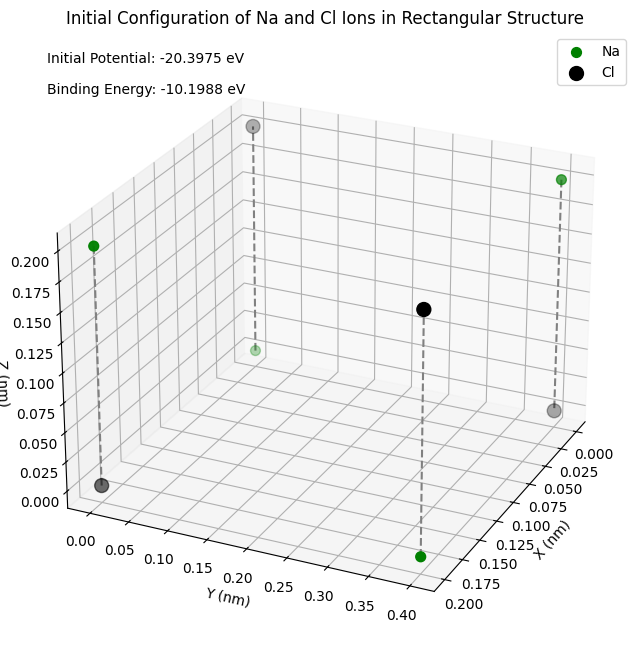

In [5]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Na ions as smaller dots
na_scatter = ax.scatter(r_na[:, 0], r_na[:, 1], r_na[:, 2], c='green', label='Na', s=50)
# Plot Cl ions with different sizes and colors
cl_scatter = ax.scatter(r_cl[:, 0], r_cl[:, 1], r_cl[:, 2], c='black', label='Cl', s=100)

# Add lines connecting pairs of ions
for i in range(len(r_na)):
    ax.plot([r_na[i, 0], r_cl[i, 0]], [r_na[i, 1], r_cl[i, 1]], [r_na[i, 2], r_cl[i, 2]], color='gray', linestyle='--')

# Labeling and visualization settings
ax.set_xlabel('X (nm)')
ax.set_ylabel('Y (nm)')
ax.set_zlabel('Z (nm)')
ax.legend()
ax.view_init(elev=25, azim=25)

# Add text with initial potential and binding energy
ax.text2D(0.05, 0.95, f'Initial Potential: {U_init:.4f} eV', transform=ax.transAxes)
ax.text2D(0.05, 0.90, f'Binding Energy: {binding_energy:.4f} eV', transform=ax.transAxes)

# Add a title to the plot
ax.set_title('Initial Configuration of Na and Cl Ions in Rectangular Structure')

# Show the 3D plot
plt.show()

In [ ]:
res = scipy.optimize.minimize( fun=cluster, x0=vals_init, tol=1e-3, method="BFGS")
cluster.set_vals(res.x)  # For some reason, "minimize" is not updating the class at the last iteration
print ("Final optimized cluster positions")
print(cluster.positions)
print("Final potential:", res.fun)

# Calculate and print the binding energy
binding_energy = cluster.binding_energy()
print(f"\nBinding Energy: {binding_energy:.4f} eV")

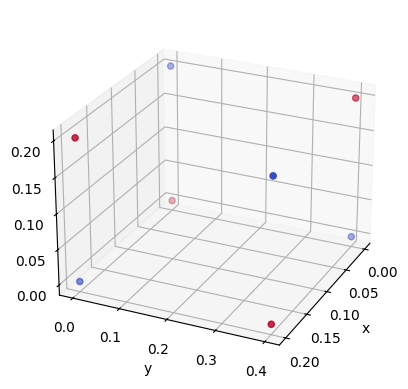

In [7]:
#%matplotlib line

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

charges = cluster.charges
x,y,z = cluster.positions[:, 0], cluster.positions[:, 1], cluster.positions[:, 2]
ax.scatter( x,y,z, c=charges, cmap='coolwarm' )
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=25, azim=25)
plt.show()

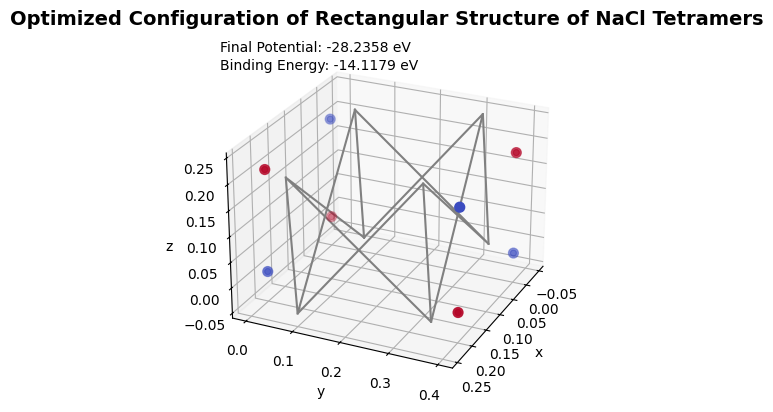